In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

import pickle
import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import joblib
import logging
from datetime import datetime
from argparse import ArgumentParser
import src.utils as utils
from src.utils import normalize_answer, find_subsequence, exact_match_score
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

/drive2/ryusejong/miniconda3/envs/dagcd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-2per-seed0-un.parquet')

# evaluate Greedy
print('------------------Greedy------------------')
greedy_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'greedy_ans')
greedy_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'greedy_ans')

print(f"EM: {greedy_em * 100}")
print(f"F1: {greedy_f1 * 100}\n")

# evaluate RAG Hallu
print('------------------RAG Hallu------------------')
ours_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'pred_ans')
ours_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'pred_ans')


print(f"EM: {ours_em * 100}")
print(f"F1: {ours_f1 * 100}\n")

------------------Greedy------------------
EM: 43.22
F1: 53.61

------------------RAG Hallu------------------
EM: 43.22
F1: 53.61



In [3]:
correct = []
incorrect = []

correct_avg_entropy = []
incorrect_avg_entropy = []

correct_top_entropy = []
incorrect_top_entropy = []

correct_answer_prob = []
incorrect_answer_prob = []

correct_low_answer_prob = []
incorrect_low_answer_prob = []

for i, item in enumerate(data):

    if exact_match_score(item['gold_ans'][0], item['pred_ans']):
        correct.append(item)
        correct_avg_entropy.append(-item['avg_entropy'])
        correct_top_entropy.append(-item['top_entropy'])
        correct_answer_prob.append(item['answer_prob'])
        correct_low_answer_prob.append(item['low_answer_prob'])
    else:
        incorrect.append(item)
        incorrect_avg_entropy.append(-item['avg_entropy'])
        incorrect_top_entropy.append(-item['top_entropy'])
        incorrect_answer_prob.append(item['answer_prob'])
        incorrect_low_answer_prob.append(item['low_answer_prob'])
        
print(f"Total correct: {100 * len(correct) / len(data): .2f}%")
print('-'*50)
print(f"Correct average entropy: {np.mean(correct_avg_entropy): .4f}")
print(f"Incorrect average entropy: {np.mean(incorrect_avg_entropy): .4f}")
print('-'*50)
print(f"Correct top entropy: {np.mean(correct_top_entropy): .4f}")
print(f"Incorrect top entropy: {np.mean(incorrect_top_entropy): .4f}")
print('-'*50)
print(f"Correct answer prob: {np.mean(correct_answer_prob): .4f}")
print(f"Incorrect answer prob: {np.mean(incorrect_answer_prob): .4f}")
print('-'*50)
print(f"Correct low answer prob: {np.mean(correct_low_answer_prob): .4f}")
print(f"Incorrect low answer prob: {np.mean(incorrect_low_answer_prob): .4f}")

Total correct:  43.22%
--------------------------------------------------
Correct average entropy: -1.2322
Incorrect average entropy: -1.6291
--------------------------------------------------
Correct top entropy: -2.8013
Incorrect top entropy: -3.8518
--------------------------------------------------
Correct answer prob:  0.7087
Incorrect answer prob:  0.5750
--------------------------------------------------
Correct low answer prob:  0.4430
Incorrect low answer prob:  0.2413


/tmp/ipykernel_16446/486272806.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([correct_avg_entropy, incorrect_avg_entropy], labels=['Correct', 'Incorrect'])
/tmp/ipykernel_16446/486272806.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([correct_top_entropy, incorrect_top_entropy], labels=['Correct', 'Incorrect'])
/tmp/ipykernel_16446/486272806.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([correct_answer_prob, incorrect_answer_prob], labels=['Correct', 'Incorrect'])
/tmp/ipykernel_16446/486272806.py:23: MatplotlibDeprecationWarning: The 'labels' paramete

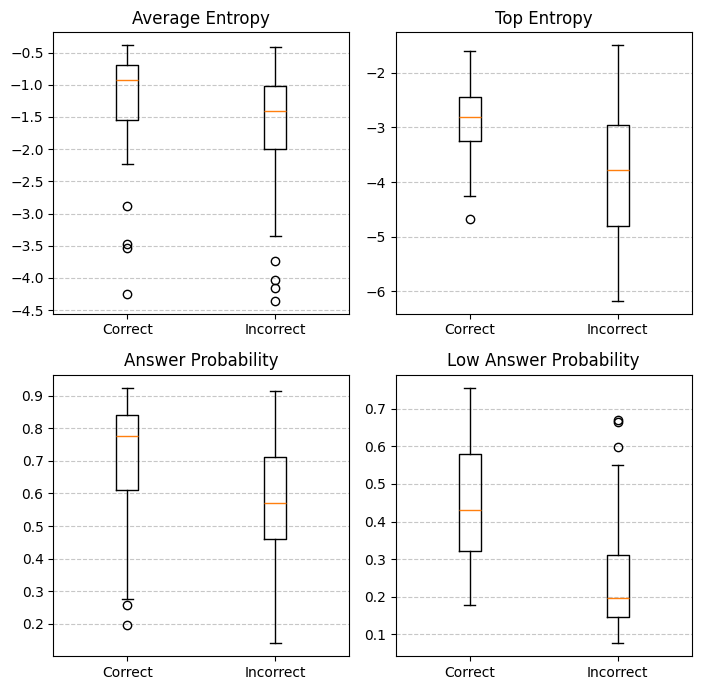

In [4]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot 1: Avg Entropy
axes[0].boxplot([correct_avg_entropy, incorrect_avg_entropy], labels=['Correct', 'Incorrect'])
axes[0].set_title('Average Entropy')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Top Entropy
axes[1].boxplot([correct_top_entropy, incorrect_top_entropy], labels=['Correct', 'Incorrect'])
axes[1].set_title('Top Entropy')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Answer Probability
axes[2].boxplot([correct_answer_prob, incorrect_answer_prob], labels=['Correct', 'Incorrect'])
axes[2].set_title('Answer Probability')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Low Answer Probability
axes[3].boxplot([correct_low_answer_prob, incorrect_low_answer_prob], labels=['Correct', 'Incorrect'])
axes[3].set_title('Low Answer Probability')
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

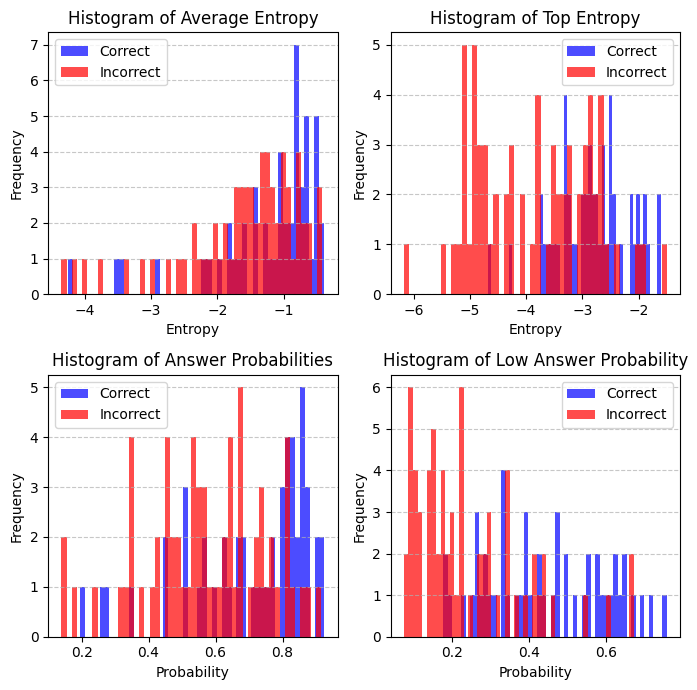

In [5]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot 2: Avg Entropy
axes[0].hist(correct_avg_entropy, bins=50, alpha=0.7, color='blue', label='Correct')
axes[0].hist(incorrect_avg_entropy, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[0].set_title('Histogram of Average Entropy')
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Top Entropy
axes[1].hist(correct_top_entropy, bins=50, alpha=0.7, color='blue', label='Correct')
axes[1].hist(incorrect_top_entropy, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[1].set_title('Histogram of Top Entropy')
axes[1].set_xlabel('Entropy')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Answer Probability
axes[2].hist(correct_answer_prob, bins=50, alpha=0.7, color='blue', label='Correct')
axes[2].hist(incorrect_answer_prob, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[2].set_title('Histogram of Answer Probabilities')
axes[2].set_xlabel('Probability')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(axis='y', linestyle='--', alpha=0.7)


# Plot 1: Low Answer Probability
axes[3].hist(correct_low_answer_prob, bins=50, alpha=0.7, color='blue', label='Correct')
axes[3].hist(incorrect_low_answer_prob, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[3].set_title('Histogram of Low Answer Probability')
axes[3].set_xlabel('Probability')
axes[3].set_ylabel('Frequency')
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [6]:
def evaluate_and_plot_roc(metrics):
    """
    metrics: List of tuples -> (metric_name, correct_scores, incorrect_scores)
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for ax, (title, correct, incorrect) in zip(axes.flatten(), metrics):
        # 1. 데이터 준비
        all_probs = correct + incorrect
        all_labels = [1] * len(correct) + [0] * len(incorrect)

        # 2. AUC 계산
        auc = roc_auc_score(all_labels, all_probs)

        # 3. ROC curve
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

        # 4. Youden index → 최적 threshold
        youden_index = tpr - fpr
        optimal_idx = youden_index.argmax()
        optimal_threshold = thresholds[optimal_idx]

        # 5. Accuracy 계산
        predictions = [1 if prob >= optimal_threshold else 0 for prob in all_probs]
        correct_preds = sum(p == l for p, l in zip(predictions, all_labels))
        accuracy = correct_preds / len(all_labels)
        
        # Confusion matrix 구성
        TP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 1)
        TN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 0)
        FP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 0)
        FN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 1)

        # Precision, Recall, F1-score 계산
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


        # 6. 시각화
        ax.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_title(f"{title}\nAcc: {accuracy:.4f}, F1: {f1:.4f}, Thresh: {optimal_threshold:.4f}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


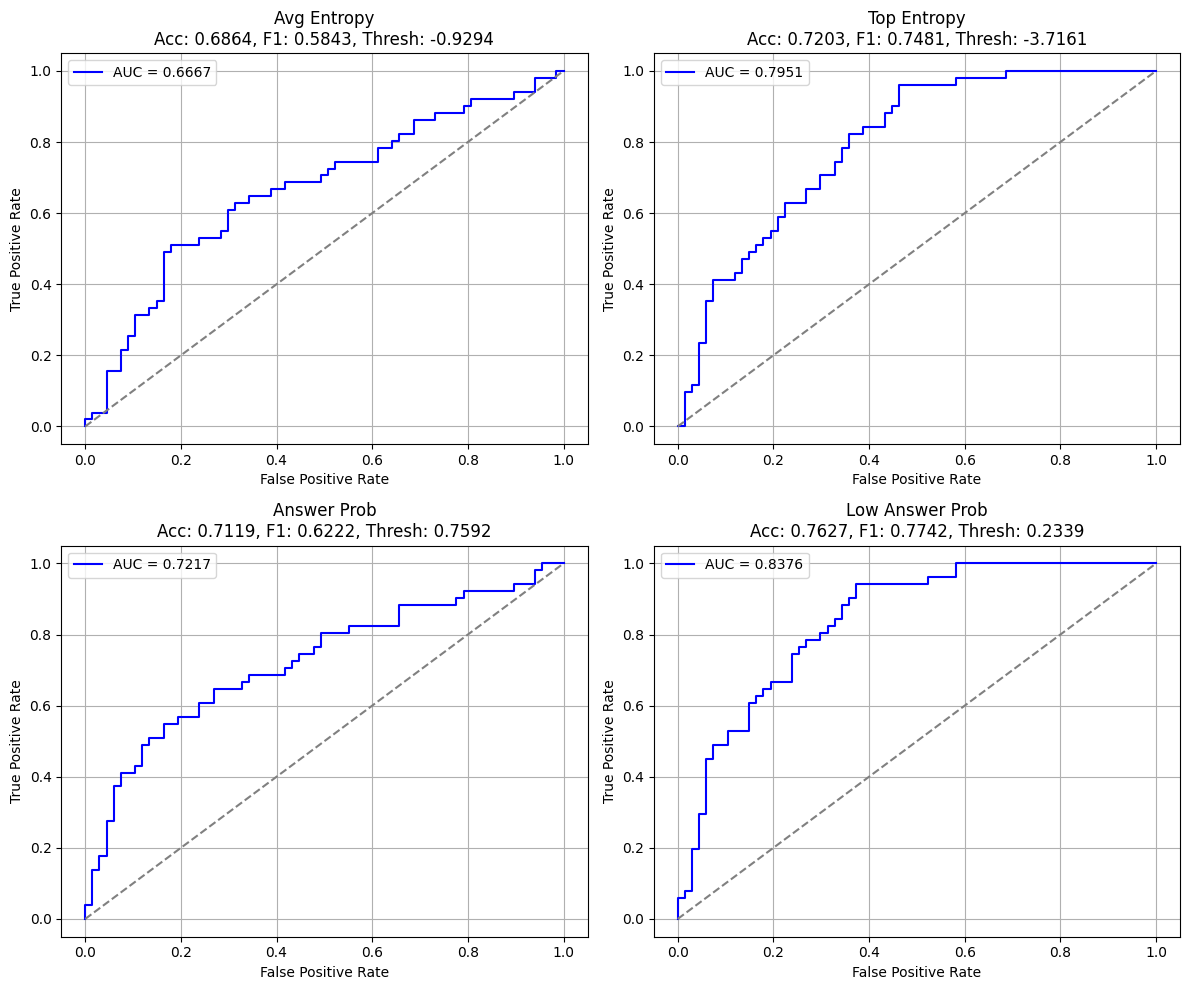

In [7]:
# 이미 수집된 uncertainty 값들
metrics = [
    ("Avg Entropy", correct_avg_entropy, incorrect_avg_entropy),
    ("Top Entropy", correct_top_entropy, incorrect_top_entropy),
    ("Answer Prob", correct_answer_prob, incorrect_answer_prob),
    ("Low Answer Prob", correct_low_answer_prob, incorrect_low_answer_prob)
]

# 평가 및 시각화
evaluate_and_plot_roc(metrics)